In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import os

os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import glob
from itertools import chain
#import os
import random
import zipfile
from tqdm import tqdm

#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

In [3]:
PATH_TRAIN = "../dataset/ox102flower/train"
PATH_VALID = "../dataset/ox102flower/valid"

In [4]:
class TripletData(Dataset):
    def __init__(self, path, transforms, split="train"):
        self.path = path
        self.split = split    # train or valid
        self.cats = 102       # number of categories
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # our positive class for the triplet
        idx = str(idx%self.cats + 1)
        
        # choosing our pair of positive images (im1, im2)
        positives = os.listdir(os.path.join(self.path, idx))
        im1, im2 = random.sample(positives, 2)
        
        # choosing a negative class and negative image (im3)
        negative_cats = [str(x+1) for x in range(self.cats)]
        negative_cats.remove(idx)
        negative_cat = str(random.choice(negative_cats))
        negatives = os.listdir(os.path.join(self.path, negative_cat))
        im3 = random.choice(negatives)
        
        im1 = os.path.join(self.path, idx, im1)
        im2 = os.path.join(self.path, idx, im2)
        im3 = os.path.join(self.path, negative_cat, im3)
        
        im1 = self.transforms(Image.open(im1))
        im2 = self.transforms(Image.open(im2))
        im3 = self.transforms(Image.open(im3))
        
        return [im1, im2, im3]
        
    # we'll put some value that we want since there can be far too many triplets possible
    # multiples of the number of images/ number of categories is a good choice
    def __len__(self):
        return self.cats*8
    

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Datasets and Dataloaders
train_data = TripletData(PATH_TRAIN, train_transforms)
val_data = TripletData(PATH_VALID, val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=32, shuffle=False, num_workers=4)

In [5]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    # Distances in embedding space is calculated in euclidean
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [6]:
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

# Our base model
model = models.resnet18().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = TripletLoss()

# Training
for epoch in range(epochs):
    
    model.train()
    epoch_loss = 0.0
    for data in tqdm(train_loader):
        optimizer.zero_grad()
        x1,x2,x3 = data
        e1 = model(x1.to(device))
        e2 = model(x2.to(device))
        e3 = model(x3.to(device)) 
        
        loss = triplet_loss(e1,e2,e3)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    print("Train Loss: {}".format(epoch_loss.item()))

  0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 148.39723205566406


  0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 29.60515022277832


  0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 18.203481674194336


  0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 13.802119255065918


100%|██████████| 26/26 [00:09<00:00,  2.35it/s]

Train Loss: 13.157190322875977


In [7]:
!pip install --user faiss-gpu

In [7]:
#!pip install faiss-gpu
import faiss                            
faiss_index = faiss.IndexFlatL2(1000)   # build the index

im_indices = []
with torch.no_grad():
    for f in glob.glob(os.path.join(PATH_TRAIN, '*/*')):
        im = Image.open(f)
        im = im.resize((224,224))
        im = torch.tensor([val_transforms(im).numpy()]).cuda()
    
        preds = model(im)
        preds = np.array([preds[0].cpu().numpy()])
        faiss_index.add(preds) #add the representation to index
        im_indices.append(f)   #store the image name to find it later on

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


In [8]:
PATH_TEST = "../dataset/ox102flower/test/"

In [9]:
with torch.no_grad():
    for f in os.listdir(PATH_TEST):
        im = Image.open(os.path.join(PATH_TEST,f))
        im = im.resize((224,224))
        im = torch.tensor([val_transforms(im).numpy()]).cuda()
    
        test_embed = model(im).cpu().numpy()
        _, I = faiss_index.search(test_embed, 5)
        print("Query: {} Retrieved: {}".format(os.path.join(PATH_TEST,f), im_indices[I[0][0]]))

Query: ../dataset/ox102flower/test/image_00006.jpg Retrieved: ../dataset/ox102flower/train/66/image_05569.jpg
Query: ../dataset/ox102flower/test/image_00025.jpg Retrieved: ../dataset/ox102flower/train/10/image_08094.jpg
Query: ../dataset/ox102flower/test/image_00029.jpg Retrieved: ../dataset/ox102flower/train/77/image_00030.jpg
Query: ../dataset/ox102flower/test/image_00060.jpg Retrieved: ../dataset/ox102flower/train/98/image_07790.jpg
Query: ../dataset/ox102flower/test/image_00092.jpg Retrieved: ../dataset/ox102flower/train/73/image_00338.jpg
Query: ../dataset/ox102flower/test/image_00099.jpg Retrieved: ../dataset/ox102flower/train/77/image_00193.jpg
Query: ../dataset/ox102flower/test/image_00114.jpg Retrieved: ../dataset/ox102flower/train/92/image_03071.jpg
Query: ../dataset/ox102flower/test/image_00176.jpg Retrieved: ../dataset/ox102flower/train/94/image_07307.jpg
Query: ../dataset/ox102flower/test/image_00177.jpg Retrieved: ../dataset/ox102flower/train/77/image_00049.jpg
Query: ../

query: 


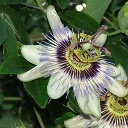

retrieved: 


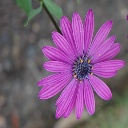

In [27]:
from IPython.display import Image, display
# imshow()メソッドで，画像を呼び出せるようにする
def imshow(img):
    '''画像を Notebook 上にインラインで縮小して表示'''
    height = img.shape[0]
    width = img.shape[1]
    #print(width, height)
    dst = cv2.resize(img, dsize=(128, 128))
    _, encimg = cv2.imencode('.jpg', dst)
    display(Image(encimg))
    
# ここから
print("query: ")
img = cv2.imread("../dataset/ox102flower/test/image_00006.jpg", cv2.IMREAD_COLOR)
imshow(img)

print("retrieved: ")
img = cv2.imread("../dataset/ox102flower/train/66/image_05569.jpg", cv2.IMREAD_COLOR)
imshow(img)

query: 


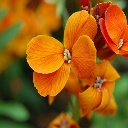

retrieved: 


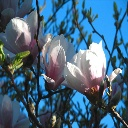

In [28]:
print("query: ")
img = cv2.imread("../dataset/ox102flower/test/image_01090.jpg", cv2.IMREAD_COLOR)
imshow(img)

print("retrieved: ")
img = cv2.imread("../dataset/ox102flower/train/87/image_05482.jpg", cv2.IMREAD_COLOR)
imshow(img)

query: 


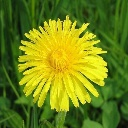

retrieved: 


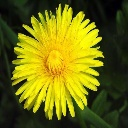

In [29]:
print("query: ")
img = cv2.imread("../dataset/ox102flower/test/image_06318.jpg", cv2.IMREAD_COLOR)
imshow(img)

print("retrieved: ")
img = cv2.imread("../dataset/ox102flower/train/50/image_06303.jpg", cv2.IMREAD_COLOR)
imshow(img)